In [48]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import gaussian_kde, linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from scipy import stats

sys.path.insert(1, '../')
from SeasonalPlot_Functions import *

from MasterPlot_Functions import *

import cmasher as cmr
import matplotlib as mpl

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest                   # CMasher
cmap = mpl.colormaps['cmr.seaweed']  # MPL

In [8]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [9]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Load and prepare data
#### All events data

In [10]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)

present=df_long[df_long['Climate']=='Present'].copy()
future=df_long[df_long['Climate']=='Future'].copy()
# nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

In [11]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")
df_changes_byduration = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur.csv")
df_changes_byduration_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydur.csv")

In [23]:
df_merged = pd.merge(df_changes_all, tbo_vals[['gauge_num', 'Critical_interarrival_time', 'Lon', 'Lat']], on='gauge_num', how='left')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,8), sharey=True)
ax[0].scatter(df_merged['D_mean_present'], df_merged['Critical_interarrival_time'])
ax[0].set_xlabel('D50 mean')
ax[0].set_ylabel('Tb0')

## Breakding down time into sin and cos components

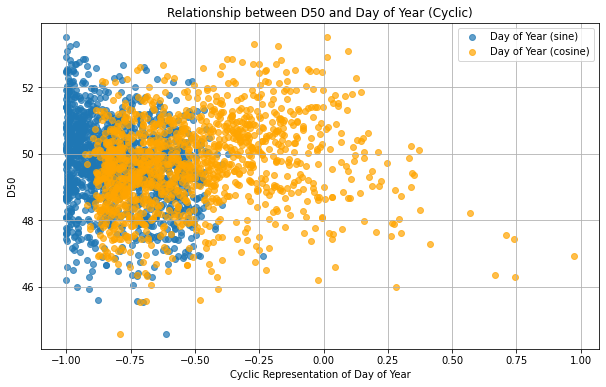

In [20]:
df_changes_all['day_sin'] = np.sin(2 * np.pi * df_changes_all['D_mean_present'] / 365.25)
df_changes_all['day_cos'] = np.cos(2 * np.pi * df_changes_all['D_mean_present'] / 365.25)

# Create a scatter plot with D50 against the day of the year in a cyclic form
plt.figure(figsize=(10, 6))
plt.scatter(df_changes_all['day_sin'], df_changes_all['D50_mean_present'], alpha=0.7, label='Day of Year (sine)')
plt.scatter(df_changes_all['day_cos'], df_changes_all['D50_mean_present'], alpha=0.7, label='Day of Year (cosine)', color='orange')

plt.xlabel("Cyclic Representation of Day of Year")
plt.ylabel("D50")
plt.title("Relationship between D50 and Day of Year (Cyclic)")
plt.legend()
plt.grid(True)
plt.show()

### 3D scatter plot, looking at relationship between multiple variables at once

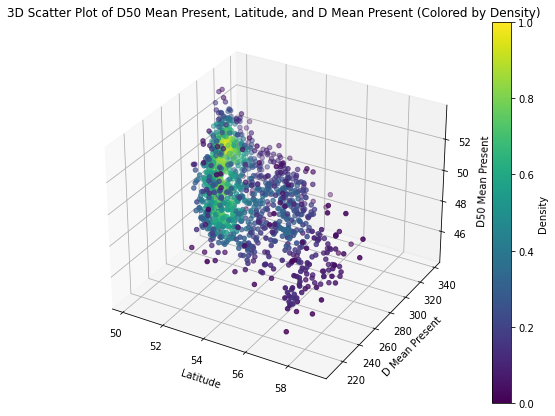

R-squared value: 0.2720


In [31]:
# Calculate density
xyz = np.vstack([df_merged['Lat'], df_merged['D_mean_future'], df_merged['D50_mean_present']])
density = gaussian_kde(xyz)(xyz)

# Normalize density for coloring
density = (density - density.min()) / (density.max() - density.min())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using density for color
sc = ax.scatter(
    df_merged['Lat'],
    df_merged['D_mean_future'],
    df_merged['D50_mean_present'],
    c=density,               # Use density for colors
    cmap='viridis',          # Colormap for density
    marker='o'
)

# Add a color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Density')

# Set labels
ax.set_xlabel('Latitude')
ax.set_ylabel('D Mean Present')
ax.set_zlabel('D50 Mean Present')
ax.set_title('3D Scatter Plot of D50 Mean Present, Latitude, and D Mean Present (Colored by Density)')

plt.show()

# Fit a Linear Regression Model for demonstration
X = df_merged[['Lat', 'D_mean_future']]  # Independent variables
y = df_merged['D50_mean_present']           # Dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Calculate R-squared value
predictions = model.predict(X)
r_squared = r2_score(y, predictions)
print(f'R-squared value: {r_squared:.4f}')


In [37]:
# fig, ax = plt.subplots(ncols=2, figsize=(10,8), sharey=False)

# plot_contour(ax[0], df_merged['D50_mean_present'],df_merged['Lat'], "",)
# plot_contour(ax[1], df_merged['D50_mean_present'],df_merged['Lon'], "",)
# # ax[0].scatter(df_merged['D50_mean_present'], df_merged['Lat'])
# # ax[0].set_xlabel('D50 mean')
# # ax[0].set_ylabel('Tb0')

# # # ax[0].scatter(df_changes_all['D50_mean_present'], df_changes_all['theta_mean_future'])
# # ax[1].scatter(df_merged['D50_mean_present'], df_merged['Lon'])
# # ax[1].set_xlabel('D50 mean')
# # # ax[1].set_ylabel('Theta');

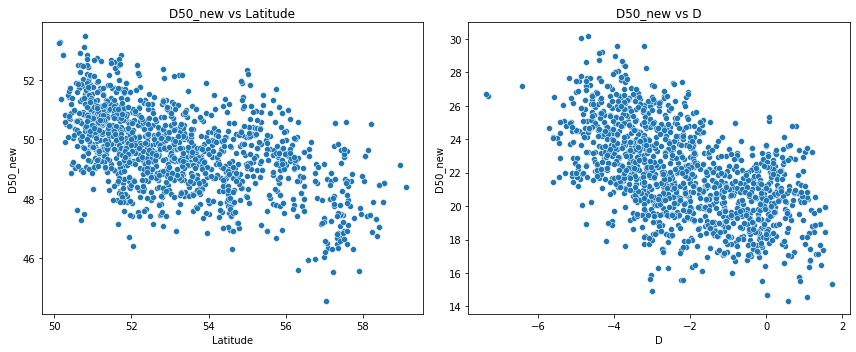

R-squared value: 0.2726


In [40]:
# Step 2: Visualize relationships
# Scatter plot for D50_new vs Lat

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Lat', y='D50_mean_present', data=df_merged)
plt.title('D50_new vs Latitude')
plt.xlabel('Latitude')
plt.ylabel('D50_new')

# Scatter plot for D50_new vs D
plt.subplot(1, 2, 2)
sns.scatterplot(x='Lon', y='D50_P10_present', data=df_merged)
plt.title('D50_new vs D')
plt.xlabel('D')
plt.ylabel('D50_new')

plt.tight_layout()
plt.show()

# Step 3: Fit a Linear Regression Model
# Define the features (independent variables) and the target (dependent variable)
X = df_merged[['Lat', 'D_mean_present']]  # Independent variables
y = df_merged['D50_mean_present']      # Dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Step 4: Calculate R-squared value
predictions = model.predict(X)
r_squared = r2_score(y, predictions)
print(f'R-squared value: {r_squared:.4f}')

Text(0.5, 33.0, 'Day of Year')

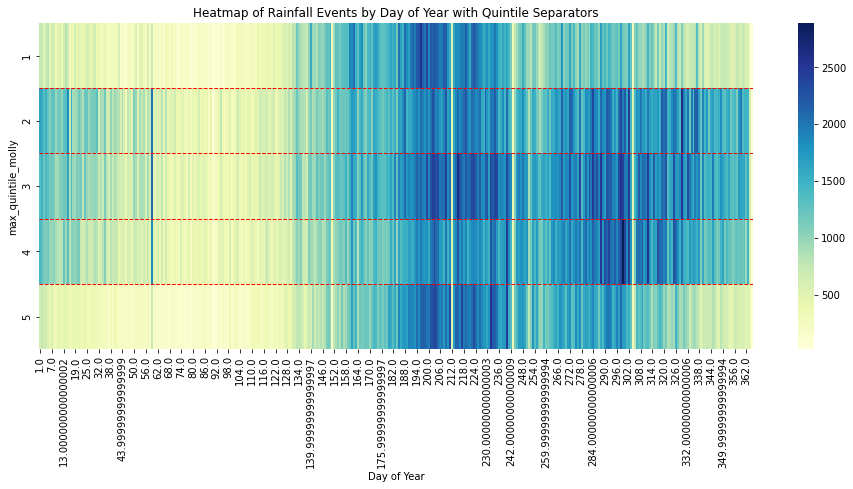

In [43]:
df=df_long
frequency_table = pd.crosstab(df['max_quintile_molly'], df['D'])

# Plot the heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(frequency_table, cmap="YlGnBu", )
# Add vertical lines at quintile boundaries

# quintiles = np.percentile(range(1, 366), [20, 40, 60, 80])
for q in [1,2,3,4]:
    plt.axhline(y=q, color='red', linestyle='--', linewidth=1)

# Add titles and labels
plt.title('Heatmap of Rainfall Events by Day of Year with Quintile Separators')
plt.xlabel('Day of Year')
# plt.ylabel('Rainfall Event Category')


Pairwise Mann-Whitney U Test Results:

Pairwise Mann-Whitney U Test Results:


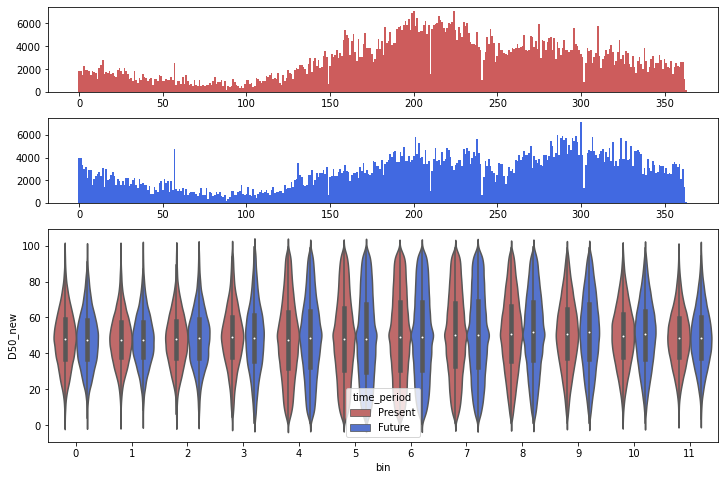

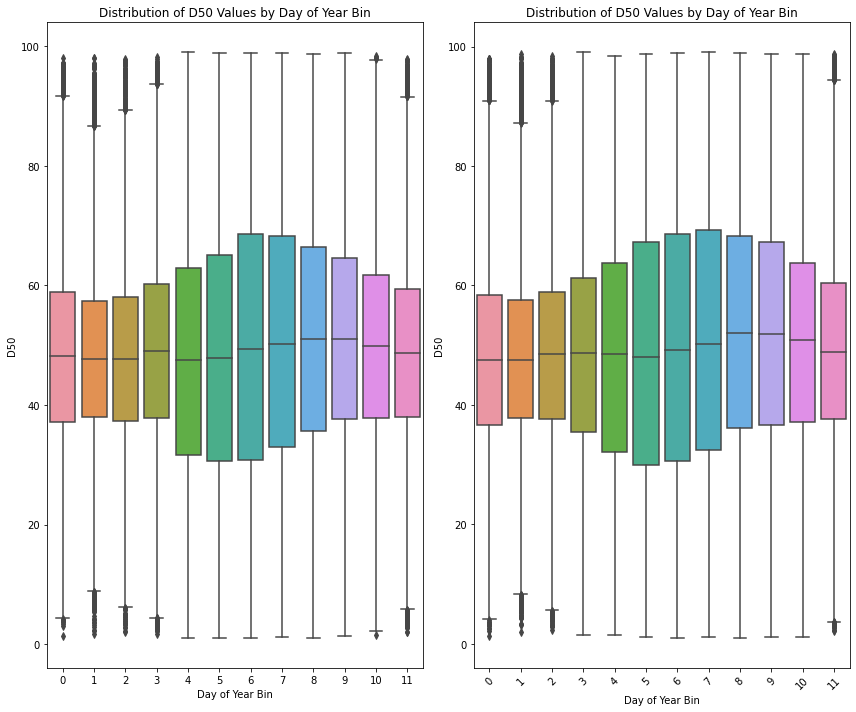

In [44]:
from scipy.stats import kruskal, mannwhitneyu

# data=df_long['D']
# full_data = np.arange(1, 366)

# # Find missing values
# missing_values = np.setdiff1d(full_data, data)

# print("Missing values:", missing_values)


# Combine the present and future data with an additional column to differentiate them
present['time_period'] = 'Present'
future['time_period'] = 'Future'

# Concatenate the two DataFrames
combined_df = pd.concat([present, future])

# Define bin edges and bin labels
bin_edges = np.arange(0, 365, 30)
combined_df['bin'] = pd.cut(combined_df['D'], bins=bin_edges, labels=range(len(bin_edges)-1))

# Plot D50 distributions for each bin, with side-by-side boxplots for Present and Future
fig, axs = plt.subplots(nrows =3, figsize=(12, 8), sharex=False, gridspec_kw={'height_ratios': [2,2,5]})

vals, counts = np.unique(present['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

vals, counts = np.unique(future['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[1].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='royalblue', linewidth=2, width=1)

sns.violinplot(x='bin', y='D50_new', hue='time_period', data=combined_df, ax=axs[2], palette = ['indianred', 'royalblue'])

# Customize plot labels and appearance
# ax.set_xlabel('Day of Year Bin')
# ax.set_ylabel('D50')
# ax.set_title('Side-by-Side Distribution of D50 Values by Day of Year Bin for Present and Future')
# plt.xticks(rotation=45)
# plt.tight_layout()

from scipy.stats import kruskal, mannwhitneyu

fig, axs = plt.subplots(ncols=2, figsize=(12, 10))

# Assume you have your data in a DataFrame called 'df'
# with columns 'day_of_year' and 'D50'

# Divide the day of year into 20-day bins
bin_edges = np.arange(0, 365, 30)
present['bin'] = pd.cut(present['D'], bins=bin_edges, labels=range(len(bin_edges)-1))

# Compute summary statistics for D50 values in each bin
d50_stats = present.groupby('bin')['D50_new'].agg(['mean', 'median', 'std'])
# print(d50_stats)

# Test for significant differences in D50 distributions across bins
_, p_value = kruskal(*[present.loc[present['bin'] == b, 'D50_new'] for b in present['bin'].unique()])
# print(f"Kruskal-Wallis p-value: {p_value:.3f}")

# Perform pairwise comparisons using Mann-Whitney U test
for i in range(len(bin_edges)-1):
    for j in range(i+1, len(bin_edges)-1):
        _, p_value = mannwhitneyu(present.loc[present['bin'] == i, 'D50'],
                                 present.loc[present['bin'] == j, 'D50'])
#         print(f"Mann-Whitney U test between bins {i} and {j}: p-value = {p_value:.3f}")
        
        

# Visualize the D50 distributions for each bin

sns.boxplot(x='bin', y='D50_new', data=present, ax=axs[0])
axs[0].set_xlabel('Day of Year Bin')
axs[0].set_ylabel('D50')
axs[0].set_title('Distribution of D50 Values by Day of Year Bin')
plt.xticks(rotation=45)
plt.tight_layout()

# Summarize the key outcomes
# print("Summary of D50 Distributions by Day of Year Bin:")
# print(d50_stats)

# print(f"\nKruskal-Wallis Test p-value: {p_value:.3f}")
# print("The Kruskal-Wallis test indicates that there are statistically significant differences in the D50 value distributions across the day of year bins.")

print("\nPairwise Mann-Whitney U Test Results:")
for i in range(len(bin_edges)-1):
    for j in range(i+1, len(bin_edges)-1):
        _, p_value = mannwhitneyu(present.loc[present['bin'] == i, 'D50'],
                                 present.loc[present['bin'] == j, 'D50'])
        if p_value < 0.05:
#             print(f"Bins {i} and {j} have statistically different D50 distributions (p-value = {p_value:.3f})")
            pass
        else:
            pass
#             print(f"Bins {i} and {j} do not have statistically different D50 distributions (p-value = {p_value:.3f})")  


# Assume you have your data in a DataFrame called 'df'
# with columns 'day_of_year' and 'D50'

# Divide the day of year into 20-day bins
bin_edges = np.arange(0, 365, 30)
future['bin'] = pd.cut(future['D'], bins=bin_edges, labels=range(len(bin_edges)-1))

# Compute summary statistics for D50 values in each bin
d50_stats = future.groupby('bin')['D50_new'].agg(['mean', 'median', 'std'])
# print(d50_stats)

# Test for significant differences in D50 distributions across bins
_, p_value = kruskal(*[future.loc[future['bin'] == b, 'D50_new'] for b in future['bin'].unique()])
# print(f"Kruskal-Wallis p-value: {p_value:.3f}")

# Perform pairwise comparisons using Mann-Whitney U test
for i in range(len(bin_edges)-1):
    for j in range(i+1, len(bin_edges)-1):
        _, p_value = mannwhitneyu(future.loc[future['bin'] == i, 'D50'],
                                 future.loc[future['bin'] == j, 'D50'])
#         print(f"Mann-Whitney U test between bins {i} and {j}: p-value = {p_value:.3f}")
        
        

# Visualize the D50 distributions for each bin

sns.boxplot(x='bin', y='D50_new', data=future, ax=axs[1])
axs[1].set_xlabel('Day of Year Bin')
axs[1].set_ylabel('D50')
axs[1].set_title('Distribution of D50 Values by Day of Year Bin')
plt.xticks(rotation=45)
plt.tight_layout()

# Summarize the key outcomes
# print("Summary of D50 Distributions by Day of Year Bin:")
# print(d50_stats)

# print(f"\nKruskal-Wallis Test p-value: {p_value:.3f}")
# print("The Kruskal-Wallis test indicates that there are statistically significant differences in the D50 value distributions across the day of year bins.")

print("\nPairwise Mann-Whitney U Test Results:")
for i in range(len(bin_edges)-1):
    for j in range(i+1, len(bin_edges)-1):
        _, p_value = mannwhitneyu(future.loc[future['bin'] == i, 'D50'],
                                 future.loc[future['bin'] == j, 'D50'])
        if p_value < 0.05:
#             print(f"Bins {i} and {j} have statistically different D50 distributions (p-value = {p_value:.3f})")
            pass
        else:
            pass
#             print(f"Bins {i} and {j} do not have statistically different D50 distributions (p-value = {p_value:.3f})")        


             mean     median        std
season                                 
Autumn  50.220466  50.074382  18.030818
Spring  48.035961  47.881198  21.407882
Summer  50.265140  50.034638  23.143637
Winter  48.203781  48.121524  15.203353
Kruskal-Wallis p-value: 0.000
Mann-Whitney U test between Summer and Spring: p-value = 0.000
Mann-Whitney U test between Summer and Autumn: p-value = 0.290
Mann-Whitney U test between Summer and Winter: p-value = 0.000
Mann-Whitney U test between Spring and Autumn: p-value = 0.000
Mann-Whitney U test between Spring and Winter: p-value = 0.000
Mann-Whitney U test between Autumn and Winter: p-value = 0.000


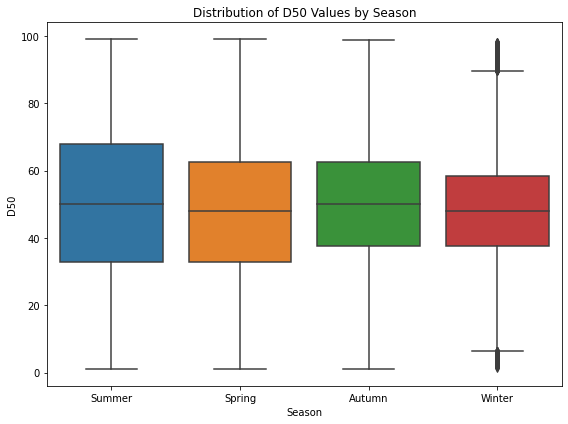

In [45]:
# Compute summary statistics for D50 values in each season
d50_stats = present.groupby('season')['D50_new'].agg(['mean', 'median', 'std'])
print(d50_stats)

# Test for significant differences in D50 distributions across seasons
_, p_value = kruskal(*[present.loc[present['season'] == s, 'D50_new'] for s in df['season'].unique()])
print(f"Kruskal-Wallis p-value: {p_value:.3f}")

# Perform pairwise comparisons using Mann-Whitney U test
for i, season1 in enumerate(present['season'].unique()):
    for j, season2 in enumerate(present['season'].unique()):
        if i < j:
            _, p_value = mannwhitneyu(present.loc[present['season'] == season1, 'D50_new'],
                                     present.loc[present['season'] == season2, 'D50_new'])
            print(f"Mann-Whitney U test between {season1} and {season2}: p-value = {p_value:.3f}")
            
            
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='season', y='D50_new', data=present, ax=ax)
ax.set_xlabel('Season')
ax.set_ylabel('D50')
ax.set_title('Distribution of D50 Values by Season')
plt.tight_layout()            

ANOVA result: F_onewayResult(statistic=917.104914173684, pvalue=0.0)


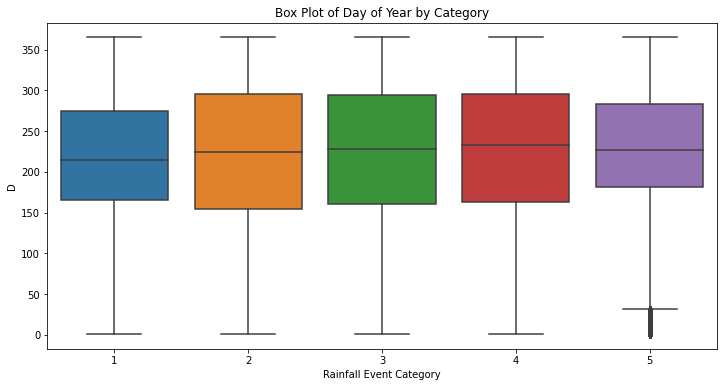

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='max_quintile_molly', y='D')
plt.title('Box Plot of Day of Year by Category')
plt.xlabel('Rainfall Event Category')

# ANOVA test
groups = [df[df['max_quintile_molly'] == cat]['D'] for cat in df['max_quintile_molly'].unique()]
anova_result = stats.f_oneway(*groups)
print('ANOVA result:', anova_result)